# Problem Statement:
Homonyms, words with shared spelling or pronunciation but distinct meanings, introduce ambiguity in natural language processing, affecting sentiment analysis and conversational AI accuracy. Developing solutions to disambiguate homonyms based on context is crucial for improving language-based application performance and user experience.

## Table of Contents

1. [**Step 1: Install and Import Required Libraries**](#step-1--install-and-import-required-libraries)
2. [**Step 2: Check if SentimentIntensityAnalyzer from NLTK is Homonym-Aware Sentiment Analyzer**](#step-2--check-if-sentimentintensityanalyzer-from-nltk-is-homonym-aware-sentiment-analyzer)
3. [**Step 3: Check if distilbert BERT base uncased can help in Homonym-Aware Sentiment Analysis**](#step-3--check-if-distilbert-bert-base-uncased-can-help-in-homonym-aware-sentiment-analysis)
4. [**Step 4: Data Exploration**](#step-4--data-exploration)
5. [**Step 5: Fine-Tune DistilBERT base uncased on SST-2 dataset from GLUE**](#step-5--fine-tune-distilbert-base-uncased-on-sst-2-dataset-from-glue)
   - [**Step 5-1: Loading the Pretrained Model**](#step-5-1--loading-the-pretrained-model)
   - [**Step 5-2: Tokenization**](#step-5-2--tokenization)
   - [**Step 5-3: Finalizing the Shape of Data**](#step-5-3--finalizing-the-shape-of-data)
   - [**Step 5-4: Train the Model**](#step-5-4--train-the-model)
6. [**Step 6: Infer using the fine-tuned model**](#step-6--infer-using-the-fine-tuned-model)
   - [**Step 6-1: Infer on Whole Sentence**](#step-6-1--infer-on-whole-sentence)
   - [**Step 6-2: Infer on Splitted Sentence**](#step-6-2--infer-on-splitted-sentence)

## Step 1 : Install and Import Required Libraries

In [ ]:
!pip install transformers

In [ ]:
!pip install transformers datasets

In [ ]:
!pip install torch

In [ ]:
!pip install datasets --upgrade

In [5]:
!pip install accelerate>=0.20.1

In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install matplotlib

In [ ]:
!pip install spacy-wordnet

In [9]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import spacy
import nltk
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from datasets import load_dataset
from transformers import BertTokenizerFast
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DistilBertForSequenceClassification, DistilBertTokenizer
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import pipeline
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from nltk.corpus import wordnet

In [11]:
# Check if CUDA (GPU support) is available
print("GPU is available: ", torch.cuda.is_available())

GPU is available:  True


## Step 2 : Check if SentimentIntensityAnalyzer from NLTK is Homonym-Aware Sentiment Analyzer

In [ ]:
# Download the VADER Lexicon using the nltk library
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Function to perform sentiment analysis
def overall_sentiment_analysis(sentence):
    # Tokenize the sentence using spaCy
    doc = nlp(sentence)

    # Initialize SentimentIntensityAnalyzer from NLTK
    sia = SentimentIntensityAnalyzer()

    # Aggregate sentiment scores for the entire sentence
    sentence_sentiment = 0
    for token in doc:
        aspect = token.text.lower()  # Use lowercase for uniformity
        sentiment_score = sia.polarity_scores(aspect)["compound"]
        sentence_sentiment += sentiment_score

    # Determine overall sentiment label based on the aggregated score
    if sentence_sentiment >= 0.05:
        overall_sentiment_label = "positive"
    elif sentence_sentiment <= -0.05:
        overall_sentiment_label = "negative"
    else:
        overall_sentiment_label = "neutral"

    return overall_sentiment_label

In [ ]:
# Example sentences
sentence1 = "I hate the selfishness in you"
sentence2 = "I hate anyone who can hurt you"
sentence3 = "I will despise anyone despises you"

# Perform overall sentiment analysis
overall_sentiment1 = overall_sentiment_analysis(sentence1)
overall_sentiment2 = overall_sentiment_analysis(sentence2)
overall_sentiment3 = overall_sentiment_analysis(sentence3)

# Format and print results
def print_sentiment_result(sentence, result):
    print("Sentence:", sentence)
    print("Predicted Sentiment:", overall_sentiment2)
    print("==============================")

# Print results for each sentence
print_sentiment_result(sentence1, overall_sentiment1)
print_sentiment_result(sentence2, overall_sentiment2)
print_sentiment_result(sentence3, overall_sentiment3)

Sentence: I hate the selfishness in you
Predicted Sentiment: negative
Sentence: I hate anyone who can hurt you
Predicted Sentiment: negative
Sentence: I will despise anyone despises you
Predicted Sentiment: negative


## Step 3 : Check if distilbert BERT base uncased can help in Homonym-Aware Sentiment Analysis

In [ ]:
# Define the sentiment analyzer using BERT base uncased
sentiment_analyzer_bert = pipeline("sentiment-analysis", model="distilbert-base-uncased")

# Example sentences
sentence1 = "I hate the selfishness in you"
sentence2 = "I hate anyone who can hurt you"
sentence3 = "I will despise anyone despises you"
# Perform sentiment analysis
result1 = sentiment_analyzer_bert(sentence1)
result2 = sentiment_analyzer_bert(sentence2)
result3 = sentiment_analyzer_bert(sentence3)

# Format and print results
def print_sentiment_result(sentence, result):
    print("Sentence:", sentence)

    # Map label to negative or positive
    sentiment_category = "negative" if result[0]['label'] == 'LABEL_1' else "positive"

    print("Predicted Sentiment:", sentiment_category)
    print("==============================")

# Print results for each sentence
print_sentiment_result(sentence1, result1)
print_sentiment_result(sentence2, result2)
print_sentiment_result(sentence3, result3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sentence: I hate the selfishness in you
Predicted Sentiment: negative
Sentence: I hate anyone who can hurt you
Predicted Sentiment: negative
Sentence: I will despise anyone despises you
Predicted Sentiment: negative


## Step 4 : Data Exploration

In [ ]:
# Load the GLUE dataset for SST-2
dataset = load_dataset("glue", "sst2")

In [ ]:
# Split the dataset into training, validation, and test sets
train_dataset = dataset["train"]
valid_dataset = dataset["validation"]

In [ ]:
# Extracting sentences from the training dataset
sentences = train_dataset["sentence"]

In [ ]:
# Calculate the lengths of sentences in terms of the number of words
sentence_lengths = [len(sentence.split()) for sentence in sentences]

In [ ]:
# Find the maximum length
max_length = max(sentence_lengths)

# Calculate the average length
average_length = sum(sentence_lengths) / len(sentence_lengths)

print(f"The maximum sentence length is: {max_length} words.")
print(f"The average sentence length is: {average_length:.2f} words.")

The maximum sentence length is: 52 words.
The average sentence length is: 9.41 words.


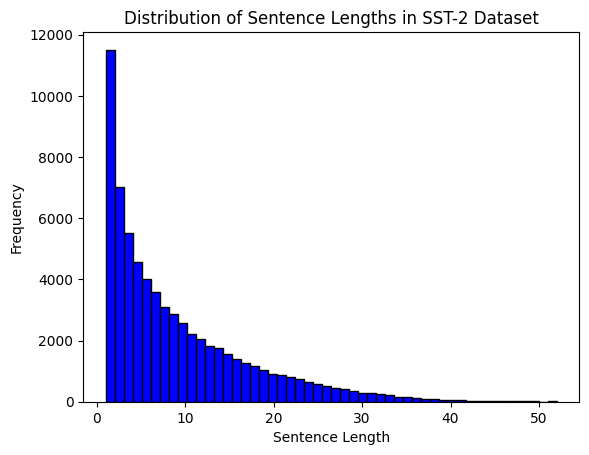

In [ ]:
# Plotting the histogram
plt.hist(sentence_lengths, bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Sentence Lengths in SST-2 Dataset')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

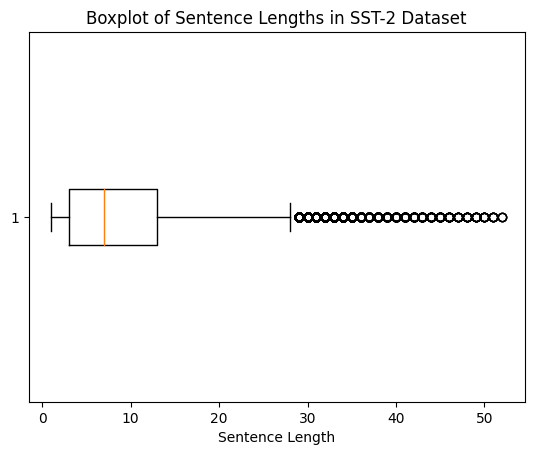

In [ ]:
# Create a boxplot
plt.boxplot(sentence_lengths, vert=False)

# Add labels and title
plt.xlabel('Sentence Length')
plt.title('Boxplot of Sentence Lengths in SST-2 Dataset')

# Show the plot
plt.show()

## Step 5 : Fine-Tune DistilBERT base uncased on SST-2 dataset from GLUE

In [ ]:
batch_size = 128  # Set the batch size for training
weight_decay = 0.01  # Set the weight decay for regularization during training
learning_rate = 2e-5  # Set the learning rate for the optimizer during training
num_train_epochs = 3  # Set the number of training epochs
max_len = 32  # Set the maximum length of input sequences

In [ ]:
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Step 5-1 : Loading the Pretrained Model

In [ ]:
# Load the pretrained model and tokenizer
model_name = "distilbert-base-uncased"
model = (AutoModelForSequenceClassification.from_pretrained(model_name,
                                                            num_labels = 2).to(device))
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Step 5-2 : Tokenization

In [ ]:
# Tokenize the sentences in the dataset using DistilBERT tokenizer
def tokenize_data(dataset):
    input_ids = []
    attention_masks = []

    # Use tqdm for a progress bar
    for sentence in tqdm(dataset['sentence'], desc="Tokenizing"):

        # Tokenize the modified sentence using DistilBERT tokenizer
        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0), torch.tensor(dataset['label'])

In [ ]:
# Tokenize the sentences in the training dataset using DistilBERT tokenizer
train_input_ids, train_attention_masks, train_labels = tokenize_data(train_dataset)

# Tokenize the sentences in the validation dataset using DistilBERT tokenizer
validation_input_ids, validation_attention_masks, validation_labels = tokenize_data(valid_dataset)

Tokenizing: 100%|██████████| 872/872 [00:00<00:00, 5017.17it/s]


In [ ]:
# Print the shape of the training input IDs
print("Train Input IDs shape:", train_input_ids.shape)

# Print the shape of the validation input IDs
print("Validation Input IDs shape:", validation_input_ids.shape)

Train Input IDs shape: torch.Size([67349, 32])
Validation Input IDs shape: torch.Size([872, 32])


### Step 5-3 : Finalizing the Shape of  Data

In [ ]:
# Define a custom dataset class for PyTorch
class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        input_data = {
            'input_ids': torch.tensor(self.input_ids[idx]),
            'attention_mask': torch.tensor(self.attention_mask[idx])
        }
        label = torch.tensor(self.labels[idx])

        return {'input_data': input_data, 'label': label}

In [ ]:
# Create instances of the custom dataset for training and validation
train_dataset = CustomDataset(train_input_ids, train_attention_masks, train_labels)
validation_dataset = CustomDataset(validation_input_ids, validation_attention_masks, validation_labels)

In [ ]:
# Create DataLoader instances for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

### Step 5-4 : Train the Model

In [ ]:
# Set up the optimizer
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
)

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * num_train_epochs
)

In [ ]:
# Inside your training loop
for epoch in range(num_train_epochs):
    # Training phase
    model.train()
    all_train_preds = []
    all_train_labels = []

    # Wrap the train_dataloader with tqdm for the epoch
    with tqdm(train_dataloader, desc=f"Epoch {epoch + 1}", total = len(train_dataloader), position=0, leave=True) as epoch_progress:
      for batch in epoch_progress:
          input_ids = batch['input_data']['input_ids'].to(device)
          attention_mask = batch['input_data']['attention_mask'].to(device)
          labels = batch['label'].to(device)

          optimizer.zero_grad()
          outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
          # loss = outputs.loss
          # Assuming binary classification, convert labels to one-hot
          labels_one_hot = F.one_hot(labels, num_classes=2).float()
          # Calculate binary cross-entropy with logits
          logits = outputs.logits
          loss = F.binary_cross_entropy_with_logits(logits, labels_one_hot)
          loss.backward()
          optimizer.step()

          _, train_preds = torch.max(outputs.logits, dim=1)
          all_train_preds.extend(train_preds.cpu().numpy())
          all_train_labels.extend(labels.cpu().numpy())

          # Update the learning rate
          scheduler.step()

      train_accuracy = accuracy_score(all_train_labels, all_train_preds)
      train_f1 = f1_score(all_train_labels, all_train_preds)


    # Save the model after each epoch
    model.save_pretrained(f"/content/drive/MyDrive/fine_tuned_models/model_epoch_{epoch + 1}")
    tokenizer.save_pretrained(f"/content/drive/MyDrive/fine_tuned_models/model_epoch_{epoch + 1}")

    # Validation phase
    model.eval()
    all_val_preds = []
    all_val_labels = []

    # Wrap the validation_dataloader with tqdm
    with tqdm(validation_dataloader, desc=f"Validation - Epoch {epoch + 1}", total=len(validation_dataloader), position=0, leave=False) as val_progress:
      with torch.no_grad():
          for batch in val_progress:
              input_ids = batch['input_data']['input_ids'].to(device)
              attention_mask = batch['input_data']['attention_mask'].to(device)
              labels = batch['label'].to(device)
              outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
              _, val_preds = torch.max(outputs.logits, dim=1)

              all_val_preds.extend(val_preds.cpu().numpy())
              all_val_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(all_val_labels, all_val_preds)
    val_f1 = f1_score(all_val_labels, all_val_preds)
    print(f"Epoch {epoch + 1} - Training Accuracy: {train_accuracy:.4f}, Training F1: {train_f1:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1: {val_f1:.4f}")

Epoch 1: 100%|██████████| 527/527 [02:49<00:00,  3.10it/s]


Epoch 1 - Training Accuracy: 0.8888, Training F1: 0.9012, Validation Accuracy: 0.8922, Validation F1: 0.8978


Epoch 2: 100%|██████████| 527/527 [02:48<00:00,  3.13it/s]


Epoch 2 - Training Accuracy: 0.9482, Training F1: 0.9534, Validation Accuracy: 0.8945, Validation F1: 0.8989


Epoch 3: 100%|██████████| 527/527 [02:47<00:00,  3.14it/s]


Epoch 3 - Training Accuracy: 0.9635, Training F1: 0.9672, Validation Accuracy: 0.8945, Validation F1: 0.8976


## Step 6 : Infer using the fine tuned model

### Step 6-1 : Infer on Whole Sentence

In [ ]:
# Define a function to predict sentiment using the fine-tuned distilbert model
def predict_sentiment(sentences, model_path="/content/drive/MyDrive/fine_tuned_models/model_epoch_3"):
    # Load the fine-tuned model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # Set the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Lists to store predictions and logits
    all_sentiments = []
    all_confidence_scores = []

    # Loop over sentences
    for sentence in sentences:
        # Encode the sentences using the tokenizer
        encoded_sentences = tokenizer.encode_plus(
                                sentence,
                                add_special_tokens=True,
                                max_length=32,
                                padding="max_length",
                                truncation=True,
                                return_attention_mask=True,
                                return_tensors='pt'
                            )

        # Move the input tensors to the device
        input_ids = encoded_sentences["input_ids"].to(device)
        attention_mask = encoded_sentences["attention_mask"].to(device)

        # Make predictions
        with torch.no_grad():
            model.eval()
            logits = model(input_ids, attention_mask=attention_mask).logits

        # Get predicted labels
        predicted_labels = torch.argmax(logits, dim=1).tolist()

        # Map labels to sentiment strings
        sentiments = ["positive" if label == 1 else "negative" for label in predicted_labels]

        # Apply softmax to convert logits to probabilities
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        confidence_scores = probabilities.max(dim=1).values.tolist()

        # Append to the lists
        all_sentiments.append(sentiments)
        all_confidence_scores.append(confidence_scores)

    # Return the list of predicted sentiments and logits
    return all_sentiments, all_confidence_scores

In [ ]:
# Inference
sentences = ["I hate the selfishness in you", "I hate any one can hurt you", "I will despise anyone despises you", "I hate any one who can hurt you"]
predicted_sentiments, confidence_scores = predict_sentiment(sentences)

# Print the results with only four decimal places
for sentence, sentiment, confidence in zip(sentences, predicted_sentiments, confidence_scores):
    confidence_str = ', '.join(['{:.3f}'.format(score) for score in confidence])

    print(f"Sentence: {sentence}")
    print(f"Predicted Sentiment: {sentiment[0]}")
    print("=" * 30)

Sentence: I hate the selfishness in you
Predicted Sentiment: negative
Sentence: I hate any one can hurt you
Predicted Sentiment: positive
Sentence: I will despise anyone despises you
Predicted Sentiment: positive
Sentence: I hate any one who can hurt you
Predicted Sentiment: negative


### Step 6-2 : Infer on Splitted Sentence

In [16]:
# Define a function to predict sentiment using the fine-tuned distilbert model
def predict_sentiment(sentences, model_path="/content/drive/MyDrive/fine_tuned_models/model_epoch_3"):
    # Load the fine-tuned model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # Set the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Lists to store predictions and logits
    all_sentiments = []
    all_confidence_scores = []

    # Loop over sentences
    for sentence in sentences:
        # Split the sentence into two halves
        half_length = len(sentence) // 2
        first_half = sentence[:half_length].strip()
        second_half = sentence[half_length:].strip()

        print("First Half of Sentence:", first_half)
        print("Second Half of Sentence:", second_half)

        # Process the first half
        encoded_sentences_first = tokenizer.encode_plus(
                                first_half,
                                add_special_tokens=True,
                                max_length=32,
                                padding="max_length",
                                truncation=True,
                                return_attention_mask=True,
                                return_tensors='pt'
                            )

        input_ids_first = encoded_sentences_first["input_ids"].to(device)
        attention_mask_first = encoded_sentences_first["attention_mask"].to(device)

        with torch.no_grad():
            model.eval()
            logits_first = model(input_ids_first, attention_mask=attention_mask_first).logits

        predicted_labels_first = torch.argmax(logits_first, dim=1).tolist()
        sentiments_first = ["positive" if label == 1 else "negative" for label in predicted_labels_first]
        probabilities_first = torch.nn.functional.softmax(logits_first, dim=1)
        confidence_scores_first = probabilities_first.max(dim=1).values.tolist()

        # Process the second half
        encoded_sentences_second = tokenizer.encode_plus(
                                second_half,
                                add_special_tokens=True,
                                max_length=32,
                                padding="max_length",
                                truncation=True,
                                return_attention_mask=True,
                                return_tensors='pt'
                            )

        input_ids_second = encoded_sentences_second["input_ids"].to(device)
        attention_mask_second = encoded_sentences_second["attention_mask"].to(device)

        with torch.no_grad():
            model.eval()
            logits_second = model(input_ids_second, attention_mask=attention_mask_second).logits

        predicted_labels_second = torch.argmax(logits_second, dim=1).tolist()
        sentiments_second = ["positive" if label == 1 else "negative" for label in predicted_labels_second]
        probabilities_second = torch.nn.functional.softmax(logits_second, dim=1)
        confidence_scores_second = probabilities_second.max(dim=1).values.tolist()

        # Combine results for both halves
        all_sentiments.append([sentiments_first, sentiments_second])
        all_confidence_scores.append([confidence_scores_first, confidence_scores_second])

    # Return the list of predicted sentiments and logits
    return all_sentiments, all_confidence_scores

In [17]:
sentences = ["I hate any one who can hurt you"]
predicted_sentiments, confidence_scores = predict_sentiment(sentences)

# Print the results with only four decimal places
for (sentiments_first, sentiments_second), (confidence_scores_first, confidence_scores_second) in zip(
    predicted_sentiments, confidence_scores
):
    confidence_str_first = ', '.join(['{:.4f}'.format(score) for score in confidence_scores_first])
    confidence_str_second = ', '.join(['{:.4f}'.format(score) for score in confidence_scores_second])

    print("First Half - Predicted Sentiment:", sentiments_first[0])
    print("First Half - Confidence Scores:", confidence_str_first)
    print("=" * 30)

    print("Second Half - Predicted Sentiment:", sentiments_second[0])
    print("Second Half - Confidence Scores:", confidence_str_second)
    print("=" * 30)

First Half of Sentence: I hate any one
Second Half of Sentence: who can hurt you
First Half - Predicted Sentiment: negative
First Half - Confidence Scores: 0.9981
Second Half - Predicted Sentiment: negative
Second Half - Confidence Scores: 0.9948
